# 导入模块

In [1]:
import pandas as pd
import numpy as np
from typing import List
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,mean_absolute_percentage_error,mean_absolute_error,mean_squared_error,r2_score  
from sklearn.svm import SVC,SVR
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier,MLPRegressor
from sklearn.ensemble import GradientBoostingClassifier
import xgboost
import lightgbm as LGB
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.utils import shuffle
from sklearn.utils import resample  
from sklearn.metrics import confusion_matrix,roc_auc_score ,roc_curve,auc
from sklearn.model_selection import cross_val_score  
from imblearn.over_sampling import SMOTE,SVMSMOTE
from sklearn import metrics
from sklearn.ensemble import AdaBoostClassifier
from boruta import BorutaPy
from sklearn.model_selection import GridSearchCV


from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor 
from sklearn.feature_selection import SelectFromModel


# from thundersvm import SVC

In [2]:
import warnings
warnings.filterwarnings("ignore")

# 获取数据

In [3]:
data = pd.read_csv("【东软集团A08】医保特征数据16000（修订版） - 副本.csv")

In [4]:
data.head()

,个人编码,一天去两家医院的天数,就诊的月数,月就诊天数_MAX,月就诊天数_AVG,月就诊医院数_MAX,月就诊医院数_AVG,就诊次数_SUM,月就诊次数_MAX,月就诊次数_AVG,...,药品在总金额中的占比,个人支付的药品占比,检查总费用在总金额占比,个人支付检查费用占比,治疗费用在总金额占比,个人支付治疗费用占比,BZ_民政救助,BZ_城乡优抚,是否挂号,RES
0,3.521200e+14,0,6,7,5.666667,3,2.166667,34,7,5.666667,...,0.939194,0.004262,0.050817,0.0,0.007434,0.0,0,0,1,0
1,3.521200e+14,0,6,4,2.500000,2,1.333333,15,4,2.500000,...,0.955626,0.002982,0.030815,0.0,0.013398,0.0,0,0,1,0
2,3.521200e+14,8,6,8,6.166667,3,2.166667,45,9,7.500000,...,0.783610,0.000332,0.000000,0.0,0.195087,0.0,0,0,0,0
3,3.521200e+14,0,6,6,3.666667,2,1.833333,23,6,3.833333,...,0.458649,0.000184,0.000000,0.0,0.541351,0.0,0,0,0,0
4,3.521200e+14,0,6,5,4.333333,1,1.000000,26,5,4.333333,...,0.983726,0.000316,0.000000,0.0,0.016274,0.0,0,0,0,0


# 数据处理

In [5]:
data.columns[data.isnull().any()]

Index(['出院诊断LENTH_MAX'], dtype='object')

In [6]:
data[data['出院诊断病种名称_NN']==0].loc[:,['出院诊断病种名称_NN','出院诊断LENTH_MAX','RES']]

,出院诊断病种名称_NN,出院诊断LENTH_MAX,RES
120,0,NaN,0
152,0,NaN,0
172,0,NaN,0
254,0,NaN,0
274,0,NaN,0
...,...,...,...
15880,0,NaN,1
15888,0,NaN,0
15935,0,NaN,0
15963,0,NaN,0


In [7]:
data['出院诊断LENTH_MAX'].unique()

array([29., 20., 16., 33., 30., 40., 34., 28., 50., 24., 25., 13., 26.,
       45., 23., 17., 43., 14., 35., 62.,  6., 31., 22., 36., 48.,  8.,
       27., 19.,  2., 44., 54., 21., 11., 32.,  9., 59., 37., 12.,  4.,
       15., 51., 49., 42., 58., 38., 10., 41., 39., nan, 66., 57.,  3.,
       52., 18., 56., 46.,  7., 53., 65., 47., 55., 70., 61.,  5., 60.,
       67., 64., 63., 68., 69., 86., 76.])

In [8]:
data['出院诊断LENTH_MAX'] = data['出院诊断LENTH_MAX'].fillna(0)

In [9]:
data.columns[data.isnull().any()]

Index([], dtype='object')

In [10]:
# 将16000条数据整体划分为训练集和测试集
data_X = data.iloc[:,:-1]
data_y = data.iloc[:,-1]

data_train,data_test,data_train_y,data_test_y=train_test_split(data_X,data_y,test_size=0.3,random_state=12)
train_data = pd.concat([data_train, data_train_y], axis=1)
test_data = pd.concat([data_test, data_test_y], axis=1)
print("训练样本量：{} ，测试样本量：{}".format(len(train_data),len(test_data)))

训练样本量：11200 ，测试样本量：4800


In [11]:
res_0 = data[data['RES'] == 0]
res_1 = data[data['RES'] == 1]
print("整体样本0数量:{}\n整体样本1数量:{}".format(len(res_0),len(res_1)))

整体样本0数量:15207
整体样本1数量:793


In [12]:
res_0 = train_data[train_data['RES'] == 0]
res_1 = train_data[train_data['RES'] == 1]
print("训练样本0数量:{}\n训练样本1数量:{}".format(len(res_0),len(res_1)))

训练样本0数量:10639
训练样本1数量:561


# 特征选择

## 查看模型feature_importances_

[LightGBM] [Info] Number of positive: 641, number of negative: 12159
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12817
[LightGBM] [Info] Number of data points in the train set: 12800, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502723 -> initscore=0.010892
[LightGBM] [Info] Start training from score 0.010892
[LightGBM] [Info] Number of positive: 641, number of negative: 12159
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2214
[LightGBM] [Info] Number of data points in the train set: 12800, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502723 -> initscore=0.010892
[LightGBM] [Info] Start training from score 0.010892
[LightGBM] [Info] N

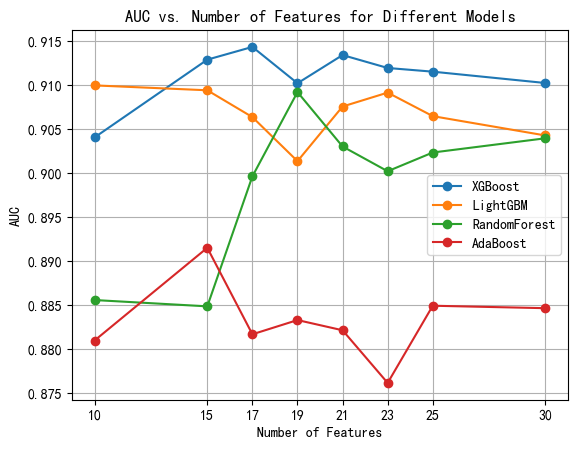

In [13]:
X = data.iloc[:,:-1]
y = data.iloc[:,-1]
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2,random_state=12)

total_samples = len(data)
class_0_samples = len(data[data['RES']==0])
class_1_samples = len(data[data['RES']==1])
class_weight={0: total_samples / (2 * class_0_samples), 1: total_samples / (2 * class_1_samples)}

# 定义函数，用于训练模型并返回在验证集上的 AUC 和所选特征的索引列表
def train_and_evaluate(model, X_train, y_train, X_val, y_val, n_features):
    # 计算特征重要性
    model.fit(X_train, y_train)
    feature_importance = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)# 从大到小排序
    
    # 选择重要性最高的 n 个特征
    selected_features = feature_importance[:n_features].index.tolist()
    X_train_selected = X_train[selected_features]
    X_val_selected = X_val[selected_features]
    
    # 训练模型
    model.fit(X_train_selected, y_train)
    
    # 在验证集上进行预测并计算 AUC
    y_pred = model.predict_proba(X_val_selected)[:, 1]
    auc1 = roc_auc_score(y_val, y_pred)
    
    return auc1, selected_features

# 初始化模型列表
models = {
    'XGBoost': xgboost.XGBClassifier(importance_type = 'gain',random_state=12,class_weight=class_weight),
    'LightGBM': LGBMClassifier(importance_type = 'gain',random_state=12,class_weight=class_weight),
    'RandomForest': RandomForestClassifier(random_state=12,class_weight=class_weight),
    'AdaBoost': AdaBoostClassifier(random_state=12),
}

# 初始化列表存储 AUC 值和所选特征列表
auc_values_dict = {model_name: [] for model_name in models.keys()}
selected_features_dict = {model_name: [] for model_name in models.keys()}

n_values = [10, 15, 17, 19, 21, 23, 25, 30]

# 遍历不同的模型
for model_name, model in models.items():
    # 遍历不同的特征数量
    for n in n_values:
        auc1, selected_features = train_and_evaluate(model, X_train, y_train, X_test, y_test, n)
        auc_values_dict[model_name].append(auc1)
        selected_features_dict[model_name].append(selected_features)

# 绘制折线图
for model_name, auc_values in auc_values_dict.items():
    plt.plot(n_values, auc_values, marker='o', label=model_name)
plt.xlabel('Number of Features')
plt.ylabel('AUC')
plt.title('AUC vs. Number of Features for Different Models')
plt.xticks(n_values)
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# 查看前15个特征
xgboost_features = selected_features_dict['XGBoost']
value1 = xgboost_features[1]
print("XGB选择特征个数：{}\n特征：{}\n".format(len(value1),value1))

LightGBM_features = selected_features_dict['LightGBM']
value2 = LightGBM_features[1]
print("LGB选择特征个数：{}\n特征：{}\n".format(len(value2),value2))

RandomForest_features = selected_features_dict['RandomForest']
value3 = RandomForest_features[1]
print("随机森林选择特征个数：{}\n特征：{}\n".format(len(value3),value3))

AdaBoost_features = selected_features_dict['AdaBoost']
value4 = AdaBoost_features[1]
print("AdaBoost选择特征个数：{}\n特征：{}".format(len(value4),value4))

XGB选择特征个数：15
特征：['月统筹金额_MAX', '月就诊次数_MAX', '本次审批金额_SUM', '药品费申报金额_SUM', '基本统筹基金支付金额_SUM', '统筹支付金额_SUM', '医疗救助个人按比例负担金额_SUM', '就诊的月数', 'ALL_SUM', '就诊次数_SUM', '月就诊天数_MAX', '交易时间DD_NN', '月药品金额_MAX', '床位费申报金额_SUM', '中草药费发生金额_SUM']

LGB选择特征个数：15
特征：['月统筹金额_MAX', '基本统筹基金支付金额_SUM', 'ALL_SUM', '本次审批金额_SUM', '月药品金额_MAX', '中草药费发生金额_SUM', '顺序号_NN', '统筹支付金额_SUM', '交易时间DD_NN', '月就诊次数_MAX', '月就诊天数_MAX', '中成药费发生金额_SUM', '医院_药品_AVG', '医院_就诊天数_MAX', '一次性医用材料申报金额_SUM']

随机森林选择特征个数：15
特征：['月统筹金额_MAX', '月药品金额_MAX', '月统筹金额_AVG', 'ALL_SUM', '统筹支付金额_SUM', '本次审批金额_SUM', '基本统筹基金支付金额_SUM', '月就诊天数_MAX', '药品费申报金额_SUM', '月就诊次数_MAX', '月就诊次数_AVG', '药品费发生金额_SUM', '顺序号_NN', '月药品金额_AVG', '起付标准以上自负比例金额_SUM']

AdaBoost选择特征个数：15
特征：['月统筹金额_MAX', '本次审批金额_SUM', '贵重药品发生金额_SUM', '统筹支付金额_SUM', '药品在总金额中的占比', '医院_就诊天数_MAX', '月药品金额_AVG', '月药品金额_MAX', '交易时间DD_NN', '顺序号_NN', '中草药费发生金额_SUM', '治疗费用在总金额占比', '基本统筹基金支付金额_SUM', '中成药费发生金额_SUM', '治疗费申报金额_SUM']


## Boruta方法
Boruta是一种全相关的特征选择方法，其他大部分都是最小最优的;这意味着它试图找到所有携带可用于预测的信息的特征，而不是找到一些可能的分类器误差最小的特征的紧凑子集。使用全相关特性是因为当机器试图理解生成数据的现象时，它应该关注所有与之相关的因素，而不仅仅是在特定方法的最显著的特征。它的核心思想是通过比较原始特征与随机生成的“影子”特征之间的重要性来确定特征的重要性。

# 特征分析
结合上面的两种方法，提取他们多次出现的特征因子以及重要性较高的特征因子

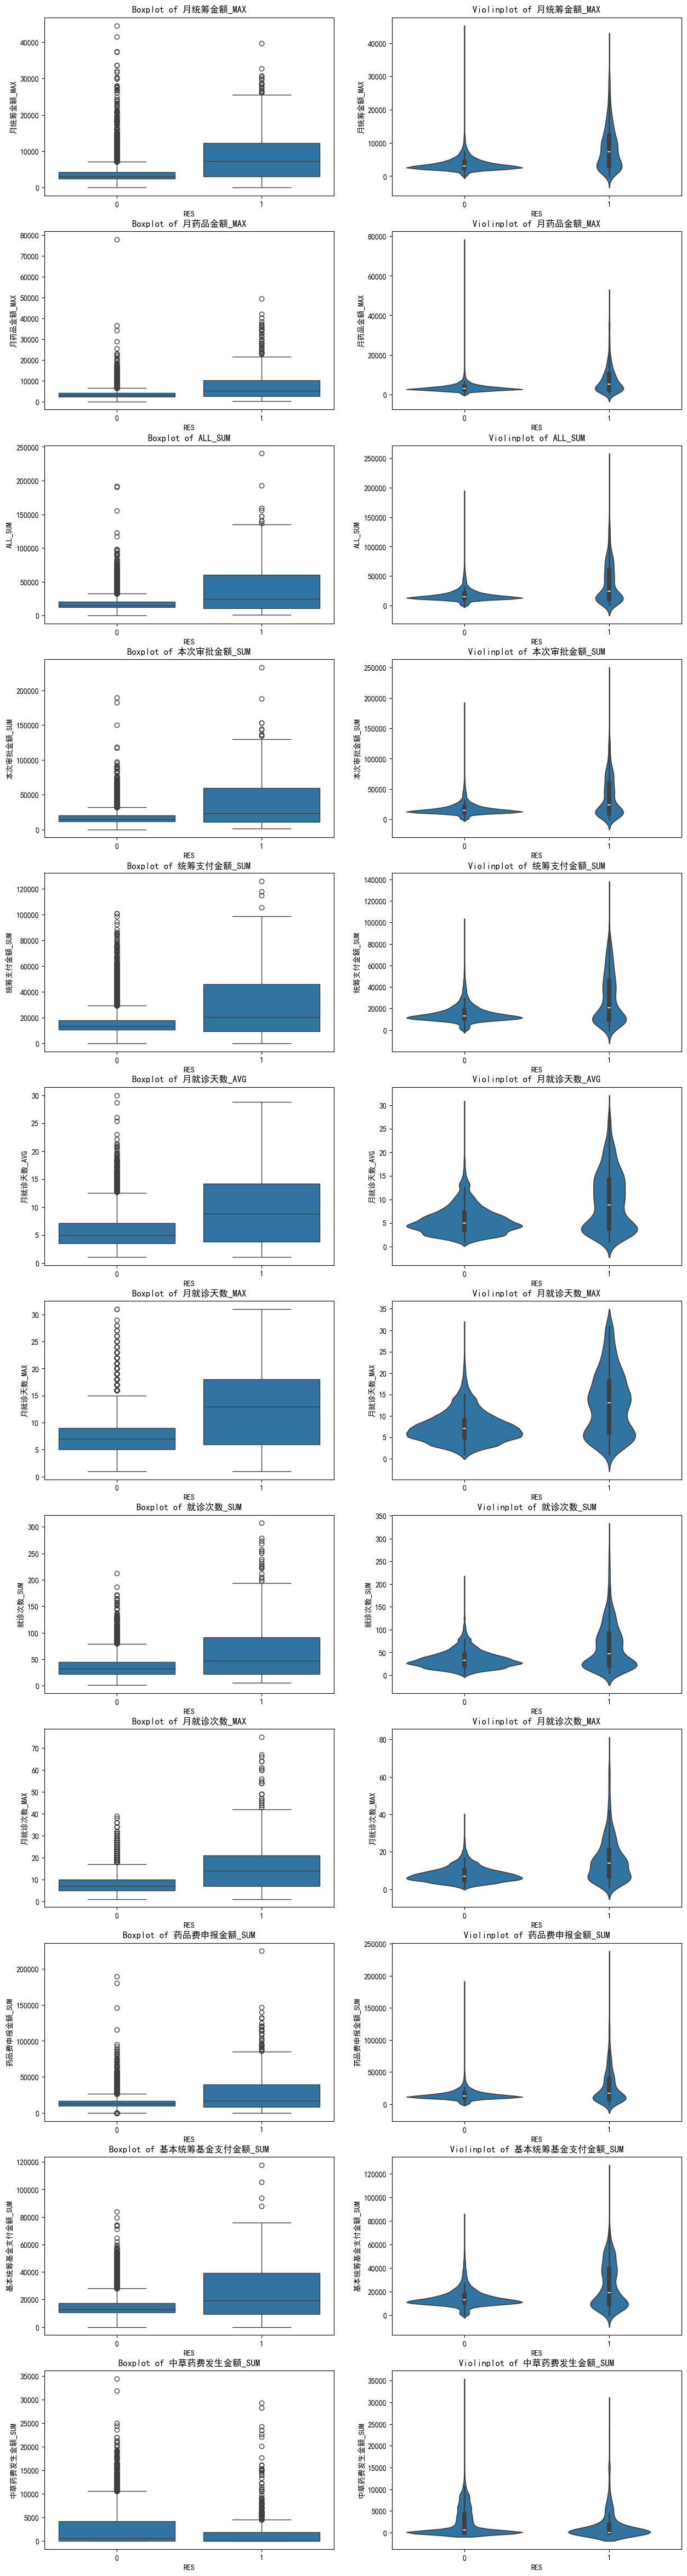

In [15]:
features = ['月统筹金额_MAX','月药品金额_MAX','ALL_SUM','本次审批金额_SUM','统筹支付金额_SUM', '月就诊天数_AVG','月就诊天数_MAX','就诊次数_SUM',
     '月就诊次数_MAX','药品费申报金额_SUM','基本统筹基金支付金额_SUM','中草药费发生金额_SUM']

fig, axes = plt.subplots(nrows=len(features), ncols=2, figsize=(15, 5*len(features)))
for i, feature in enumerate(features):
    sns.boxplot(x='RES', y=feature, data=data, ax=axes[i, 0])
    axes[i, 0].set_title(f'Boxplot of {feature}')
    sns.violinplot(x='RES', y=feature, data=data, ax=axes[i, 1])
    axes[i, 1].set_title(f'Violinplot of {feature}')

In [16]:
X = train_data.iloc[:,:-1]
y = train_data.iloc[:,-1]
X=X[['月统筹金额_MAX','月药品金额_MAX','ALL_SUM','本次审批金额_SUM','统筹支付金额_SUM', '月就诊天数_AVG','月就诊天数_MAX','就诊次数_SUM',
     '月就诊次数_MAX','药品费申报金额_SUM','基本统筹基金支付金额_SUM','中草药费发生金额_SUM']]
X.head()

,月统筹金额_MAX,月药品金额_MAX,ALL_SUM,本次审批金额_SUM,统筹支付金额_SUM,月就诊天数_AVG,月就诊天数_MAX,就诊次数_SUM,月就诊次数_MAX,药品费申报金额_SUM,基本统筹基金支付金额_SUM,中草药费发生金额_SUM
2993,7399.09,7633.97,22534.63,21837.72,18405.03,3.166667,5,19,5,21001.22,18405.03,417.48
12336,2412.89,2470.28,10987.13,10908.89,9817.95,4.500000,5,27,5,9994.91,9817.95,961.70
1962,2581.35,2554.59,12316.64,12248.89,11024.02,3.333333,6,20,6,11313.39,11024.02,0.00
9934,1879.00,1924.58,9068.69,9058.07,8152.25,2.166667,3,13,3,8381.37,8152.25,0.00
14770,8441.57,9261.54,30009.50,26840.35,22814.27,7.333333,11,45,12,20423.07,22814.27,0.00


In [17]:
lgb = LGBMClassifier(importance_type = 'gain',class_weight=class_weight,random_state=12)
lgb.fit(X, y)
test_probs = lgb.predict_proba(X)[:, 1]  
fpr, tpr, thresholds = roc_curve(y, test_probs)  
roc_auc = auc(fpr, tpr)  
print("lgb AUC:",roc_auc)

xgb = xgboost.XGBClassifier(importance_type = 'gain',class_weight=class_weight,random_state=12)
xgb.fit(X, y)
test_probs = xgb.predict_proba(X)[:, 1]
fpr, tpr, thresholds = roc_curve(y, test_probs)  
roc_auc = auc(fpr, tpr)  
print("xgb AUC:",roc_auc)

forest = RandomForestClassifier(random_state=12,class_weight=class_weight) 
forest.fit(X, y)
test_probs = forest.predict_proba(X)[:, 1]   
fpr, tpr, thresholds = roc_curve(y, test_probs)  
roc_auc = auc(fpr, tpr) 
print("forest AUC:",roc_auc)

ada = AdaBoostClassifier(random_state=12) 
ada.fit(X, y)
test_probs = ada.predict_proba(X)[:, 1] 
fpr, tpr, thresholds = roc_curve(y, test_probs)  
roc_auc = auc(fpr, tpr) 
print("ada AUC:",roc_auc)


[LightGBM] [Info] Number of positive: 561, number of negative: 10639
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2433
[LightGBM] [Info] Number of data points in the train set: 11200, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502782 -> initscore=0.011127
[LightGBM] [Info] Start training from score 0.011127
lgb AUC: 0.9975868223713278
xgb AUC: 0.9997713822901949
forest AUC: 1.0
ada AUC: 0.9351938743522429


In [18]:
X_test = test_data.loc[:,X.columns]
y_test = test_data.iloc[:,-1]

test_predict = xgb.predict(X_test)
test_probs = xgb.predict_proba(X_test)[:, 1] 
print("评估报告：\n",classification_report(y_test,test_predict))
fpr, tpr, thresholds = roc_curve(y_test, test_probs)  
roc_auc = auc(fpr, tpr)  
print("xgb AUC:",roc_auc)
print(confusion_matrix(y_test, test_predict))
print("\n-----------------------------------------------------------\n")

test_predict = lgb.predict(X_test)
test_probs = lgb.predict_proba(X_test)[:, 1]  
print("评估报告：\n",classification_report(y_test,test_predict))
fpr, tpr, thresholds = roc_curve(y_test, test_probs)  
roc_auc = auc(fpr, tpr)  
print("lgb AUC:",roc_auc)
print(confusion_matrix(y_test, test_predict))
print("\n-----------------------------------------------------------\n")

test_predict = forest.predict(X_test)
test_probs = forest.predict_proba(X_test)[:, 1]  
print("评估报告：\n",classification_report(y_test,test_predict))
fpr, tpr, thresholds = roc_curve(y_test, test_probs)  
roc_auc = auc(fpr, tpr)  
print("forest AUC:",roc_auc)
print(confusion_matrix(y_test, test_predict))
print("\n-----------------------------------------------------------\n")

test_predict = ada.predict(X_test)
test_probs = ada.predict_proba(X_test)[:, 1]  
print("评估报告：\n",classification_report(y_test,test_predict))
fpr, tpr, thresholds = roc_curve(y_test, test_probs)  
roc_auc = auc(fpr, tpr)  
print("ada AUC:",roc_auc)
print(confusion_matrix(y_test, test_predict))


评估报告：
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      4568
           1       0.69      0.41      0.51       232

    accuracy                           0.96      4800
   macro avg       0.83      0.70      0.75      4800
weighted avg       0.96      0.96      0.96      4800

xgb AUC: 0.9242858868289148
[[4525   43]
 [ 137   95]]

-----------------------------------------------------------

评估报告：
               precision    recall  f1-score   support

           0       0.98      0.94      0.96      4568
           1       0.35      0.63      0.45       232

    accuracy                           0.93      4800
   macro avg       0.67      0.79      0.71      4800
weighted avg       0.95      0.93      0.94      4800

lgb AUC: 0.922696871791775
[[4299  269]
 [  85  147]]

-----------------------------------------------------------

评估报告：
               precision    recall  f1-score   support

           0       0.97      0.99    

In [19]:
xgb = xgboost.XGBClassifier(importance_type = 'gain',class_weight=class_weight,random_state=12,learning_rate=0.15)
xgb.fit(X, y)
test_probs = xgb.predict_proba(X)[:, 1] 
fpr, tpr, thresholds = roc_curve(y, test_probs)  
roc_auc = auc(fpr, tpr)  


test_predict = xgb.predict(X_test)
test_probs = xgb.predict_proba(X_test)[:, 1] 
print("评估报告：\n",classification_report(y_test,test_predict))
fpr, tpr, thresholds = roc_curve(y_test, test_probs)  
roc_auc = auc(fpr, tpr)  
print("xgb AUC:",roc_auc)
print(confusion_matrix(y_test, test_predict))

# 设置新的阈值
new_threshold = 0.4  
new_test_predict = (test_probs >= new_threshold).astype(int)
print("修改阈值后的结果：\n")
print("评估报告：\n", classification_report(y_test, new_test_predict))
print("混淆矩阵：\n", confusion_matrix(y_test, new_test_predict))
fpr, tpr, thresholds = roc_curve(y_test, test_probs)  
roc_auc = auc(fpr, tpr)  
print("xgb AUC:",roc_auc)
test_data['predicted_RES'] = new_test_predict
test_data.to_csv('测试集分类结果.csv', index=False)

评估报告：
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      4568
           1       0.71      0.41      0.52       232

    accuracy                           0.96      4800
   macro avg       0.84      0.70      0.75      4800
weighted avg       0.96      0.96      0.96      4800

xgb AUC: 0.9214640641041125
[[4529   39]
 [ 137   95]]
修改阈值后的结果：

评估报告：
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      4568
           1       0.67      0.44      0.53       232

    accuracy                           0.96      4800
   macro avg       0.82      0.71      0.76      4800
weighted avg       0.96      0.96      0.96      4800

混淆矩阵：
 [[4517   51]
 [ 130  102]]
xgb AUC: 0.9214640641041125


In [20]:
# 随机选择一个样本的索引  
random_index = np.random.randint(0, len(X_test))  
  
# 获取该样本的特征和真实标签  
x_test_sample = X_test.iloc[random_index:random_index+1]  
y_test_sample = y_test.iloc[random_index]  

# 使用模型预测该样本的概率  
test_probs_sample = xgb.predict_proba(x_test_sample)[:, 1]  
  
# 根据设定的阈值进行预测  
new_test_predict_sample = (test_probs_sample >= new_threshold).astype(int)  
  
# 输出真实值和预测值  
print(f"随机抽取的样本索引: {random_index}")  
print(f"真实值: {y_test_sample}")  
print(f"预测为正类的概率: {test_probs_sample[0]}")  
print(f"基于阈值 {new_threshold} 的预测值: {new_test_predict_sample[0]}")  

随机抽取的样本索引: 1284
真实值: 0
预测为正类的概率: 0.0022982212249189615
基于阈值 0.4 的预测值: 0


总结：调整参数和阈值，对模型最终的效果有少许提升。

# 从业务实践角度描述模型提供的业务价值，并结合领域知识探索拓展和丰富系统的附加价值。

在欺诈分类模型中，出现特征最多且为最重要的特征为“月统筹金额_MAX”，因此对该特征进行回归预测

In [21]:
from sklearn.metrics import explained_variance_score

def regression_metrics(true,pred):
    print('回归模型评估指标结果:')
    print('平均绝对误差【MAE】:',mean_absolute_error(true,pred))
    print('均方误差【MSE】:',mean_squared_error(true,pred))
    print("均方根误差【RMSE】:",np.sqrt(mean_squared_error(true,pred))) 
    print("解释方差:",explained_variance_score(true, pred))
    print("R平方:",r2_score(true,pred))

In [22]:
new_df = data[(data['RES']==0)]

In [23]:
features = new_df.columns.drop('月统筹金额_MAX').tolist()
X = new_df[features] 
y = new_df['月统筹金额_MAX']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

model_features = []
feature_names = list(X_train.columns) 

In [24]:
def extract_top_features(model, model_name, feature_names, top_n=10):
    # 获取特征重要性
    feature_importances = model.feature_importances_
    
    # 排序特征重要性，并获取前top_n个特征及其重要性
    sorted_idx = np.argsort(feature_importances)[::-1]
    top_features_idx = sorted_idx[:top_n]
    top_features = [feature_names[i] for i in top_features_idx]
    top_importances = feature_importances[top_features_idx]
    
    # 构建DataFrame保存特征重要性
    df_features = pd.DataFrame({
        'Model': model_name,
        'Feature': top_features,
        'Importance': top_importances
    })
    
    return df_features

In [25]:

xgb_reg = xgboost.XGBRegressor(importance_type='gain',objective='reg:squarederror',eval_metric='rmse', random_state=12)  
# 训练模型  
xgb_reg.fit(X_train, y_train)  
# 预测测试集  
print("\nXGB 测试集评估：")
y_pred = xgb_reg.predict(X_test)  
regression_metrics(y_test,y_pred)
df_xgb_features = extract_top_features(xgb_reg, 'XGBoost', feature_names)

lgb_reg = LGB.LGBMRegressor(importance_type='gain', random_state=12)
# 训练模型  
lgb_reg.fit(X_train, y_train,eval_metric='rmse')  
# 预测测试集  
print("\nLGB 测试集评估：")
y_pred = lgb_reg.predict(X_test)  
regression_metrics(y_test,y_pred)

df_lgb_features = extract_top_features(lgb_reg, 'LightGBM', feature_names)


XGB 测试集评估：
回归模型评估指标结果:
平均绝对误差【MAE】: 221.81310928083894
均方误差【MSE】: 304675.6215005297
均方根误差【RMSE】: 551.9742942388981
解释方差: 0.9395227145914702
R平方: 0.9395192806695174
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12301
[LightGBM] [Info] Number of data points in the train set: 12165, number of used features: 71
[LightGBM] [Info] Start training from score 3714.632363

LGB 测试集评估：
回归模型评估指标结果:
平均绝对误差【MAE】: 219.37050832407536
均方误差【MSE】: 262760.4472437463
均方根误差【RMSE】: 512.6016457676919
解释方差: 0.947840067491857
R平方: 0.9478398016138174


In [26]:
feature_importance_df = pd.concat([df_xgb_features, df_lgb_features], ignore_index=True)
feature_importance_df

,Model,Feature,Importance
0,XGBoost,月统筹金额_AVG,5.636888e-01
1,XGBoost,月药品金额_MAX,5.563103e-02
2,XGBoost,个人支付检查费用占比,5.088895e-02
3,XGBoost,顺序号_NN,4.803763e-02
4,XGBoost,ALL_SUM,1.700249e-02
5,XGBoost,医院_药品_MAX,1.392046e-02
6,XGBoost,药品在总金额中的占比,1.376068e-02
7,XGBoost,治疗费发生金额_SUM,1.287036e-02
8,XGBoost,医院_药品_AVG,1.253298e-02
9,XGBoost,医疗救助个人按比例负担金额_SUM,1.252236e-02


In [27]:
X_train=X_train[['月统筹金额_AVG', '月药品金额_MAX', '顺序号_NN', 'ALL_SUM',
       '医院_药品_MAX', '药品在总金额中的占比', '治疗费发生金额_SUM', '医院_药品_AVG',
       '医疗救助个人按比例负担金额_SUM', '统筹支付金额_SUM', '贵重检查费金额_SUM', '医院_就诊天数_AVG',
       '月就诊天数_MAX']]
X_test=X_test[['月统筹金额_AVG', '月药品金额_MAX',  '顺序号_NN', 'ALL_SUM',
       '医院_药品_MAX', '药品在总金额中的占比', '治疗费发生金额_SUM', '医院_药品_AVG',
       '医疗救助个人按比例负担金额_SUM', '统筹支付金额_SUM', '贵重检查费金额_SUM', '医院_就诊天数_AVG',
       '月就诊天数_MAX']]

In [28]:
xgb_reg = xgboost.XGBRegressor(importance_type='gain',objective='reg:squarederror',eval_metric='rmse', random_state=12)  
# 训练模型  
xgb_reg.fit(X_train, y_train)  
# 预测测试集  
print("\nXGB 测试集评估：")
y_pred = xgb_reg.predict(X_test)  
regression_metrics(y_test,y_pred)
df_xgb_features = extract_top_features(xgb_reg, 'XGBoost', feature_names)

lgb_reg = LGB.LGBMRegressor(importance_type='gain', random_state=12)
# 训练模型  
lgb_reg.fit(X_train, y_train,eval_metric='rmse')  
# 预测测试集  
print("\nLGB 测试集评估：")
y_pred = lgb_reg.predict(X_test)  
regression_metrics(y_test,y_pred)

df_lgb_features = extract_top_features(lgb_reg, 'LightGBM', feature_names)


XGB 测试集评估：
回归模型评估指标结果:
平均绝对误差【MAE】: 223.11628893910546
均方误差【MSE】: 220340.1271375808
均方根误差【RMSE】: 469.40401269863554
解释方差: 0.9562607409217253
R平方: 0.9562605983339967
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2825
[LightGBM] [Info] Number of data points in the train set: 12165, number of used features: 13
[LightGBM] [Info] Start training from score 3714.632363

LGB 测试集评估：
回归模型评估指标结果:
平均绝对误差【MAE】: 232.18074576630477
均方误差【MSE】: 246769.3071673632
均方根误差【RMSE】: 496.7588018016019
解释方差: 0.9510141831829051
R平方: 0.951014179826196


总结：去除不相关的特征，可提升模型的预测效果。XGBoost 和 LightGBM 在模型精度上没有太大差异，但因LightGBM 在训练速度和内存利用率方面表现更优，所以在回归问题中，可选用LightGBM作为最后的模型。

In [29]:
index_to_check = np.random.randint(0, len(X_test))  # 生成一个随机索引  
x_test_sample = X_test.iloc[index_to_check:index_to_check+1]  # 选择单条记录  
y_test_sample = y_test.iloc[index_to_check]  # 选择对应的真实值  
  
# 使用LightGBM模型进行预测  
y_pred_sample = lgb_reg.predict(x_test_sample)  
  
# 打印预测值和真实值  
print(f"抽取的测试集样本索引: {index_to_check}")  
print(f"真实值: {y_test_sample}")  
print(f"LightGBM预测值: {y_pred_sample[0]}")
print(f"误差值:{y_pred_sample[0]-y_test_sample}")

抽取的测试集样本索引: 146
真实值: 2413.68
LightGBM预测值: 2442.5697013859676
误差值:28.889701385967783
